In [1]:
%matplotlib inline
import os
import cv2  
import warnings
import numpy as np
import pandas as pd
import seaborn as sn 

sn.set(font_scale=1.4)
warnings.filterwarnings('ignore')

import tensorflow as tf                
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import keras
from keras import metrics
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionResNetV2, ResNet50, Xception, VGG19, VGG16, InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

Using TensorFlow backend.


In [2]:
train_ = pd.read_csv('/kaggle/input/classification-of-images/dataset/train.csv')
test_ = pd.read_csv('/kaggle/input/classification-of-images/dataset/test.csv')
train_.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [3]:
TRAIN_PATH = '/kaggle/input/classification-of-images/dataset/Train Images/'
TEST_PATH = '/kaggle/input/classification-of-images/dataset/Test Images/'

IMAGE_SHAPE = (150, 150)
IMAGE_SHAPE_FULL = (150, 150, 3)
RESIZE_FACTOR = 255
EPOCHS = 30
BATCH_SIZE = 32

In [4]:
class_names_label = {'Food': 0, 'Attire': 1, 'Decorationandsignage': 2, 'misc': 3}
class_label_names = {v: k for k, v in class_names_label.items()}
class_names = list(class_names_label.keys())
print(class_label_names)
print(class_names_label)
nb_classes = len(class_names_label)

{0: 'Food', 1: 'Attire', 2: 'Decorationandsignage', 3: 'misc'}
{'Food': 0, 'Attire': 1, 'Decorationandsignage': 2, 'misc': 3}


In [5]:
def load_images(df, path, shape, resize, labels_provided=True):
    images = []
    labels = []
            
    for i in range(len(df.Image)):    
        image = cv2.imread(path + str(df.Image[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, shape)
        images.append(image)
        if labels_provided is True:
            labels.append(df.Class[i])
#      Not resizing currently
    if labels_provided is True:
        return np.array(images), labels
    else:
        return np.array(images)

In [6]:
train_['Class'] = train_['Class'].map(class_names_label).astype(np.uint8)
train_.head()

,Image,Class
0,image7042.jpg,0
1,image3327.jpg,3
2,image10335.jpg,1
3,image8019.jpg,0
4,image2128.jpg,1


In [7]:
train_images, train_labels = load_images(train_, TRAIN_PATH, IMAGE_SHAPE, RESIZE_FACTOR)
test_images = load_images(test_, TEST_PATH, IMAGE_SHAPE, RESIZE_FACTOR, labels_provided=False)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_images, 
                                                    to_categorical(train_labels), 
                                                    test_size=0.3, 
                                                    random_state=42)

In [9]:
def create_model(input_shape, num_classes): 
    
#     pretrain_model = ResNet50(weights='imagenet', 
#                       include_top=False, 
#                       input_shape=input_shape, 
#                       pooling='avg')
    
#     pretrain_model.trainable = False
        
#     input_tensor = Input(shape=input_shape)
#     x = pretrain_model(input_tensor)
#     output = Dense(num_classes, activation='softmax')(x)
#     model = Model(input_tensor, output)    
    
#     pretrain_model = VGG16(include_top=False, 
#                            weights='imagenet',
#                            input_shape=input_shape,
#                            pooling='avg')
    
#     pretrain_model.trainable = False
        
#     input_tensor = Input(shape=input_shape)
#     x = pretrain_model(input_tensor)
#     x = Dense(256,activation='relu')(x)
#     output = Dense(num_classes, activation='softmax')(x)
#     model = Model(input_tensor, output)
    
    base_model = VGG16(include_top=False, weights='imagenet',input_shape=input_shape, pooling='avg')
    base_model.trainable = False    
    model = Sequential()
    model.add(base_model)    
    model.add(Dense(256, activation='relu'))    
    model.add(Dense(num_classes, activation='softmax'))
        
    return model

In [10]:
keras.backend.clear_session()
model = create_model(input_shape=IMAGE_SHAPE_FULL, num_classes=nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 14,847,044
Trainable params: 132,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
earlystop = EarlyStopping(monitor='val_loss', 
                          patience=3)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [12]:
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                             samplewise_center=False,  # set each sample mean to 0
                             featurewise_std_normalization=False,  # divide inputs by std of the dataset
                             samplewise_std_normalization=False,  # divide each input by its std
                             zca_whitening=False,  # apply ZCA whitening
                             rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1, # Randomly zoom image 
                             width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                              validation_data=(X_test, y_test),
                              steps_per_epoch=len(X_train)//BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=callbacks)

Epoch 1/30
130/130 [==============================] - 27s 206ms/step - loss: 1.8439 - accuracy: 0.5982 - val_loss: 1.2045 - val_accuracy: 0.6535
Epoch 2/30
130/130 [==============================] - 23s 178ms/step - loss: 0.8878 - accuracy: 0.6901 - val_loss: 0.9758 - val_accuracy: 0.6914
Epoch 3/30
130/130 [==============================] - 23s 174ms/step - loss: 0.6937 - accuracy: 0.7394 - val_loss: 0.9018 - val_accuracy: 0.6997
Epoch 4/30
130/130 [==============================] - 23s 178ms/step - loss: 0.6076 - accuracy: 0.7582 - val_loss: 0.9180 - val_accuracy: 0.7086
Epoch 5/30
130/130 [==============================] - 23s 173ms/step - loss: 0.5487 - accuracy: 0.7875 - val_loss: 0.9033 - val_accuracy: 0.7192
Epoch 6/30
130/130 [==============================] - 22s 167ms/step - loss: 0.4843 - accuracy: 0.8099 - val_loss: 0.9530 - val_accuracy: 0.7153
Epoch 7/30
130/130 [==============================] - 23s 174ms/step - loss: 0.4627 - accuracy: 0.8215 - val_loss: 0.9177 - val_ac

In [13]:
# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1795/1795 [==============================] - 2s 1ms/step
Test loss: 1.2889646091501028
Test accuracy: 0.7298049926757812


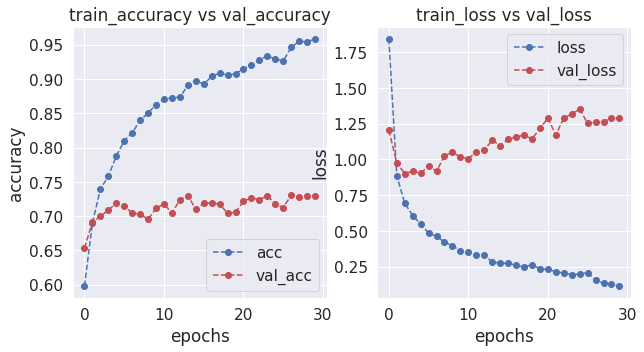

In [14]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_accuracy vs val_accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    
plot_accuracy_loss(history)    

In [15]:
pred_labels = model.predict(test_images)
pred_labels = [np.argmax(label) for label in pred_labels]
pred_class_label = [class_label_names[label] for label in pred_labels]

In [16]:
submission = pd.DataFrame({ 'Image': test_.Image, 'Class': pred_class_label })
submission.head()

,Image,Class
0,image6245.jpg,Food
1,image10409.jpg,Food
2,image8692.jpg,Food
3,image10517.jpg,Food
4,image2580.jpg,Attire


In [17]:
# Saving Model and Submission Files
now = datetime.now()
model.save('model_' + str(now) + '.h5')
submission.to_csv('submission_' + str(now) + '.csv', index=False)

In [18]:
output_dir = '/kaggle/working/'
for file in os.listdir(output_dir):    
    try:
        os.remove(output_dir + file)
    except:   
        print("Couldn't Delete: " + file)

In [19]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [20]:
pred_test_labels = model.predict(X_test)
pred_test_labels = np.array([np.argmax(label) for label in pred_test_labels])
y_test_labels = np.argmax(y_test, axis=1)

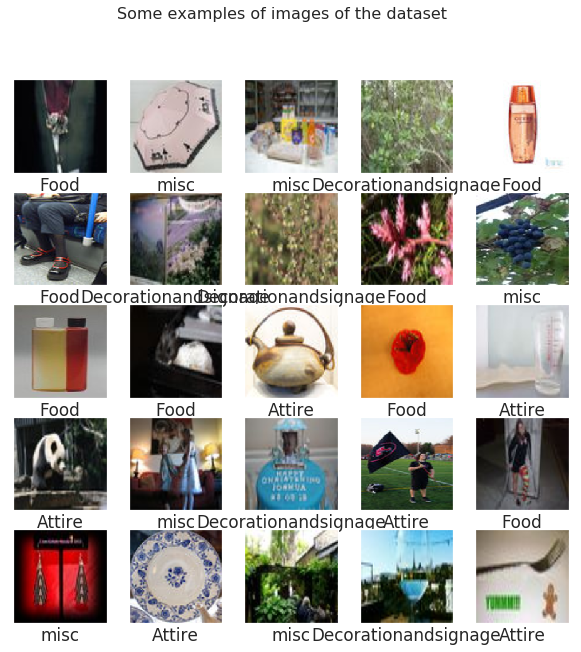

In [21]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)        
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"    
    display_examples(class_names, mislabeled_images, mislabeled_labels)


print_mislabeled_images(class_names, X_test, y_test_labels, pred_test_labels)    

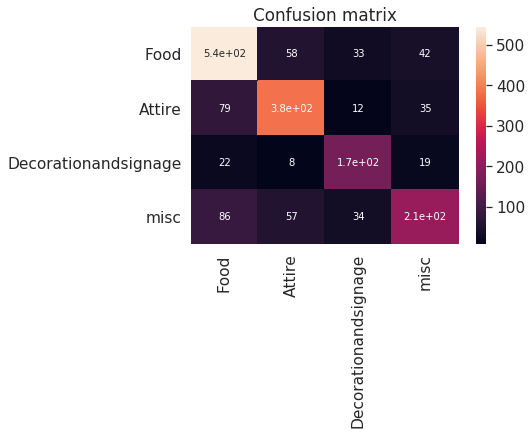

In [22]:
CM = confusion_matrix(y_test_labels, pred_test_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [23]:
# Making a bigger model
# More trainable layers at the end
# Xception check
# Attention
# Ensemble
# Confusion_Matrix
# sparse_categorical_?